In [1]:
import torch
from matplotlib import pyplot as plt
import numpy as np

In [2]:
print('torch version:',torch.__version__)

torch version: 2.4.1+cu124


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('device:', device)
else:
    device = torch.device("cpu")
    print('CUDA is not available. Using CPU.')

device: cuda


The system:

\begin{align}
 x (1-x)^3 \partial_x A &= (1-x)^2 A (1-A)  + 8 \pi x^2 A^2 \rho \; ,
 \\
 x (1-x)^3 \partial_x \alpha &= (1-x)^2 \alpha \frac{A-1}{2} + 8 \pi \alpha x^2 A S_A  \; ,
 \\
x (1-x)^2 \partial_x \chi &= - \chi \left[ (1+A)(1-x) - 8 \pi x A V(\phi) \right]
+ A x \left[ \frac{dV}{d\phi} - \left( \frac{\omega}{\alpha} \right)^2 \phi \right]  \; ,
 \\
 (1-x)^2 \partial_x \phi &= \chi
 \; ,
\end{align}

Boundary conditions:
\begin{align}
A(x=0) = 1 \,, \quad \partial_x \alpha(x=0) = 0 \,, \quad \phi(x=0) = \phi_0 \,, \quad \chi(x=0) = 0 \,,
\\
A(x=1) = 1 \,, \quad \alpha(x=1) = 1 \,, \quad \phi(x=1) = 0 \,, \quad \chi(x=1) = 0 \,.
\end{align}

The potential is
$$
V(\phi) = \frac{1}{2} m^2 \phi^2 \,, \quad \frac{d V}{d \phi} = m^2 \phi \,.
$$

To start, let's try to get a solution for fixed $\omega$ and $\phi_0$ (known solutions from Miguel A.).

In [4]:
# copied from https://github.com/benmoseley/harmonic-oscillator-pinn/blob/main/Harmonic%20oscillator%20PINN.ipynb
class FCN(torch.nn.Module):    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = torch.nn.Tanh
        
        self.fcs = torch.nn.Sequential(*[
                        torch.nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = torch.nn.Sequential(*[
                        torch.nn.Sequential(*[
                            torch.nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = torch.nn.Linear(N_HIDDEN, N_OUTPUT)

      # Apply custom weight initialization
        self.apply(self._init_weights)
    
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        act = torch.nn.Softplus()
        x = act(x)
        return x

    def _init_weights(self, m):
        if isinstance(m, torch.nn.Linear):
            # Get the size of the previous layer (input size of the current layer)
            n = m.in_features # The number of input features to this layer
            # Set the range for uniform distribution as [-1/sqrt(n), 1/sqrt(n)]
            bound = 1 / np.sqrt(n)
            # Initialize weights with a uniform distribution in the range [-bound, bound]
            torch.nn.init.uniform_(m.weight, -bound, bound)
            
            # Initialize biases to zero, only if the layer has biases
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0.0)

In [5]:
# copied from https://github.com/raimonluna/MachineLearningForStrongGravity/blob/main/Lecture1_Physics_Informed_Neural_Networks.ipynb
def gradients(outputs, inputs, order = 1):
    if order == 1:
        return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]
    elif order > 1:
        return gradients(gradients(outputs, inputs, 1), inputs, order - 1)
    else:
        return outputs

In [6]:
# random (uniform) sample points in (0,1).
def random_domain_points(n):
    #x = torch.rand((n,1), requires_grad=True)
    xhigh = 0.5*torch.rand((int(n/2),1), requires_grad=True) + 0.5 # [0.5,1)
    xlow  = -0.5*torch.rand((int(n/2),1), requires_grad=True) + 0.5 # (0,0.5]
    x = torch.cat((xlow, xhigh),0)
    return x

In [11]:
def domain_loss(u, x, omega, m): 
    A, alpha, chi_minus, phi = map(lambda i:  u[:,[i]], range(4))
    #  s.t. all vars are positive
    chi = - chi_minus
    # take derivatives
    Ax = gradients(A, x)
    alphax = gradients(alpha, x)
    chix = gradients(chi, x)
    phix = gradients(phi, x)
    
    omega = omega.to(device)
    
    # potential
    V = 0.5*torch.pow(m,2)*torch.pow(phi,2)
    # potential derivative wrt phi
    dVdphi = torch.pow(m,2)*phi
    # rho
    rho = 0.5*(torch.pow(chi,2)/A + torch.pow((omega/alpha),2)*torch.pow(phi,2)) + V
    # S_A
    SA = 0.5*(torch.pow(chi,2)/A + torch.pow((omega/alpha),2)*torch.pow(phi,2)) - V
    # eq_A is x*((1-x)^3)*A - rhs[A]
    eq_A = x*((1-x)**3)*Ax -((1-x)**2)*A*(1-A) - 8*torch.pi*(x**2)*(A**2)*rho
    # eq_alpha is x*((1-x)^3)*\p_x alpha - rhs[alpha]
    eq_alpha = x*((1-x)**3)*alphax - alpha*( 0.5*(A-1)*(1-x)**2 + 8*torch.pi*A*(x**2)*SA)
    # eq_chi  is x*((1-x)^2)*chi - rhs[chi]
    eq_chi = x*((1-x)**2)*chix + chi*( (1+A)*(1-x) - 8*torch.pi*x*A*V) - x*A*(dVdphi - torch.pow((omega/alpha),2)*phi)
    # eq_phi is ((1-x)^2)*\p_x phi - rhs[phi]
    eq_phi = ((1-x)**2)*phix - chi

    loss_dom = (torch.mean(torch.pow(eq_A,2)) + torch.mean(torch.pow(eq_alpha,2))
                + torch.mean(torch.pow(eq_chi,2)) + torch.mean(torch.pow(eq_phi,2)) 
               )
               
    return loss_dom

def x0_loss(u0, x0, phi0):    
    A, alpha, chi_minus, phi = map(lambda i:  u0[[i]], range(4))
    chi = - chi_minus
    # take derivatives
    alphax = gradients(alpha, x0)
    
    loss_x0 = torch.mean(torch.pow(A-1,2)) + torch.mean(torch.pow(alphax,2)) + torch.mean(torch.pow(phi-phi0,2)) + torch.mean(torch.pow(chi,2))
    return loss_x0

def x1_loss(u1):
    A, alpha, chi_minus, phi = map(lambda i:  u1[[i]], range(4))
    chi = - chi_minus

    loss_rmax = torch.mean(torch.pow(A-1,2)) + torch.mean(torch.pow(alpha-1,2)) + torch.mean(torch.pow(phi,2)) + torch.mean(torch.pow(chi,2))
    return loss_rmax

# impose that phi is a monotonically decreasing function
def phi_monotonic_decrease_dom(u,x):
    A, alpha, chi_minus, phi = map(lambda i:  u[:,[i]], range(4))
    chi = - chi_minus
    phix = gradients(phi, x)
    m = torch.nn.ReLU()
    penalty = torch.mean(torch.pow(m(phix),2))
    return penalty

# impose that alpha is a monotonically increasing function
def alpha_monotonic_increase_dom(u,x):
    A, alpha, chi_minus, phi = map(lambda i:  u[:,[i]], range(4))
    chi = - chi_minus
    alphax = gradients(alpha, x)
    m = torch.nn.ReLU()
    penalty = torch.mean(torch.pow(m(-alphax),2))
    return penalty


In [8]:
#torch.manual_seed(123)

# input 1 (x), output 4 (A, alpha, phi, chi), 32 nodes per layer, 3 hidden layers
# (#input, #output,#neurons in each hidden layer, #of hidden layers)
model = FCN(1,4,64,4).to(device)

#optimizer = torch.optim.Adam(list(model.parameters())+[omega],lr=1e-4)
omega = torch.nn.Parameter(0.895042*torch.ones(1))

In [9]:
optimizer = torch.optim.Adam(list(model.parameters()),lr=1e-4)

DECAY_RATE = 0.9
DECAY_STEPS = 2000
gamma = DECAY_RATE ** (1 / DECAY_STEPS)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
# true also below
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5, verbose=True) 

In [10]:
n = 1000 # number of random sampling points

epochs = 100000

#mass
m = torch.sqrt(1*torch.ones(1)).to(device)
# phi(x=0) is 0.05
phi0 = torch.ones(1).to(device)*0.05

# save all the different loss functions: 
# boundary data at x=0
# 1. loss_r0 = r0_loss(u0, r0, phi0)
# bulk of the domain
# 2. loss for the bulk of the domain: loss_dom = domain_loss(u, r, omega, m)
# 3. penalty: force phi to decrease monotonically: phi_mono_decrease = phi_monotonic_decrease_dom(u)
# 4. penalty: force alpha to increase monotonically: alpha_mono_increase = alpha_monotonic_increase_dom(u)
# boundary data at x=xmax
# 5. loss_rmax = rmax_loss(umax)

losses = torch.zeros((5,epochs)).to(device)

# all losses, weighted and added for each epoch
loss_list = []

# weigts
# r0_loss
w0 = 1000
# domain loss
w1 = 1
# rmax loss
w2 = 1000
# phi mono decrease
w3 = 1000
# alpha mono decrease
w4 = 1000

In [28]:
# to print message after how many epochs
print_message = 50

for i in range(int(epochs)):
    optimizer.zero_grad() # to make the gradients zero
    
    # left bounrady x=0
    x0 = torch.zeros(1, requires_grad=True).to(device)
    # boundary data at x=0
    u0 = model(x0)
    loss_x0 = x0_loss(u0, x0, phi0)
    
    # x sample in (0,1)
    x = random_domain_points(n).to(device)
    u = model(x)
    # loss for the bulk of the domain
    loss_dom = domain_loss(u, x, omega, m)
    # penalty: force phi to decrease monotonically
    phi_mono_decrease = phi_monotonic_decrease_dom(u,x)
    # penalty: force alpha to increase monotonically
    alpha_mono_increase = alpha_monotonic_increase_dom(u,x)
    
    # right boundary x=1
    x1 = torch.ones(1, requires_grad=True).to(device)
    # boundary data at x=xmax
    u1 = model(x1)
    loss_x1 = x1_loss(u1)

    losses[0,i] = loss_x0
    losses[1,i] = loss_dom
    losses[2,i] = loss_x1
    losses[3,i] = phi_mono_decrease
    losses[4,i] = alpha_mono_increase

    # LOSS
    loss = (w0*loss_x0 + w1*loss_dom + 
            w2*loss_x1 + 
            w3*phi_mono_decrease + w4*alpha_mono_increase
           )
    
    # save loss
    loss_list.append(loss.item())
    current_lr = scheduler.get_last_lr()[0]  # Get the current learning rate

    # print message
    if (i+1)%print_message==0:
        #print(f'Epoch: {i+1} - Loss: {loss.item():>1.3e} - Learning Rate: {current_lr:>1.3e}')
        print('epoch = ', i+1, '| loss = ', loss.item(),'| Learning Rate = ', current_lr, '|',  end='\r')

    # detach() removes the "requires_grad" and numpy() makes it a numpy item to plot later
    loss.backward() # This is for computing gradients using backward propagation
    optimizer.step()
    scheduler.step()


KeyboardInterrupt: 

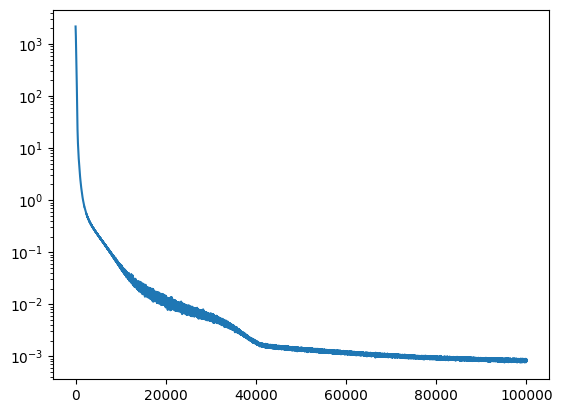

In [13]:
plt.semilogy(loss_list)

Text(0, 0.5, 'Losses[4]')

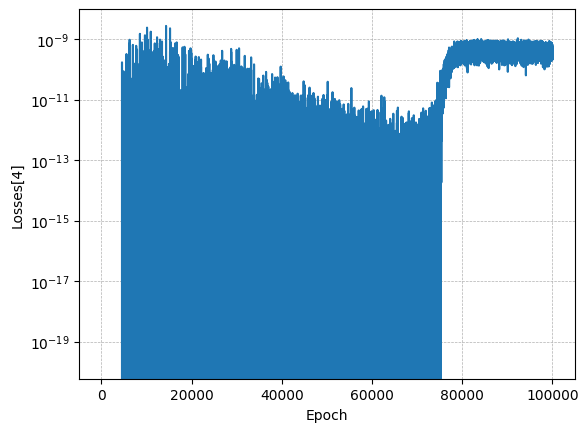

In [18]:
i = 4

ei = 0
ef = 100000

# Plot in the second subplot
plt.semilogy(losses[i, ei:ef].cpu().detach().numpy())
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel("Epoch")
plt.ylabel(f"Losses[{i}]")

In [19]:
R0 = torch.zeros(1, requires_grad=True).to(device)
nn_sol_r0 = model(R0)#.cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot
A, alpha, chi, phi = map(lambda i:  nn_sol_r0[[i]], range(4))
alphar = gradients(alpha, R0)

print("A_nn_r0 =",A.item())
print("A_r0    =",1)
print("")

print("alpha_nn_r0 =",alpha.item())
print("alpha_r0    >",0)
print("")

print("chi_nn_r0 =",chi.item())
print("chi_r0    =",0)
print("")

print("phi_nn_r0 =",phi.item())
print("phi0_r0   =",phi0.item())
print("")


print("alphar_nn_r0 =",alphar.item())
print("alphar_r0    =",0)

A_nn_r0 = 0.9999987483024597
A_r0    = 1

alpha_nn_r0 = 0.890522837638855
alpha_r0    > 0

chi_nn_r0 = 5.355838766263332e-06
chi_r0    = 0

phi_nn_r0 = 0.04998370632529259
phi0_r0   = 0.05000000074505806

alphar_nn_r0 = -2.261251211166382e-06
alphar_r0    = 0


In [22]:
x1 = torch.ones(1, requires_grad=True).to(device)
nn_sol_x1 = model(x1)#.cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot
A, alpha, chi, phi = map(lambda i:  nn_sol_x1[[i]], range(4))
alphar = gradients(alpha, x1)

print("A_nn_x1 =",A.item())
print("A_x1    =",1)
print("")

print("alpha_nn_x1 =",alpha.item())
print("alpha_x1    =",1)
print("")

print("chi_nn_x1 =",chi.item())
print("chi_x1    =",0)
print("")

print("phi_nn_x1 =",phi.item())
print("phi0_x1   =",0)

A_nn_x1 = 1.000000238418579
A_x1    = 1

alpha_nn_x1 = 0.9999980926513672
alpha_x1    = 1

chi_nn_x1 = 8.227777348324139e-10
chi_x1    = 0

phi_nn_x1 = 0.00033563829492777586
phi0_x1   = 0


In [ ]:
#plt.plot(omegas)

In [23]:
# the time domain; used to visualize the analytical solution
N = 1000
X = torch.linspace(0,1,N)#.view(-1,10)
#print(t)

# the view(-1,1) make the row tensor to a column tensor
# -1 means you dont know how many rows you need, and 1 mean that you want 1 element in each row
XX = torch.linspace(0,1,N).view(-1,1).to(device)

nn_sol = model(XX).cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot
A_nn, alpha_nn, chi_nn, phi_nn = map(lambda i:  nn_sol[:,[i]], range(4))


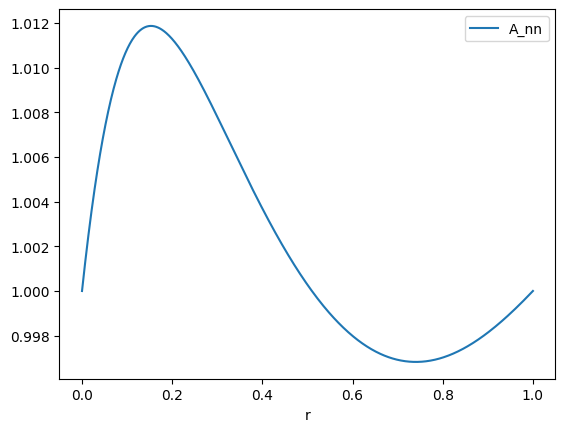

In [24]:
plt.plot(X, A_nn, label="A_nn")
plt.xlabel("r")
plt.legend()

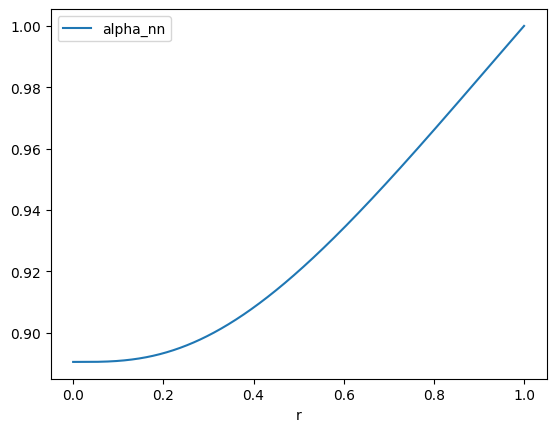

In [25]:
plt.plot(X, alpha_nn, label="alpha_nn")
plt.xlabel("r")
plt.legend()

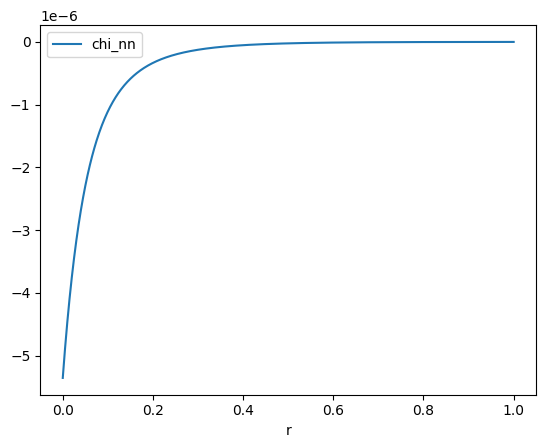

In [26]:
plt.plot(X, -chi_nn, label="chi_nn")

plt.xlabel("r")
plt.legend()

[0.04998372]


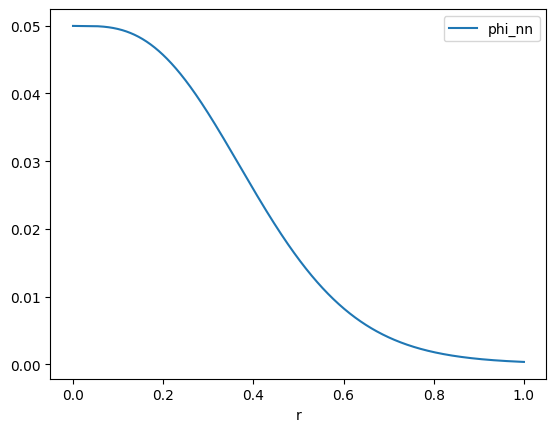

In [27]:
plt.plot(X, phi_nn, label="phi_nn")
print(phi_nn[0])
plt.xlabel("r")
#plt.ylim(0,0.2)
plt.legend()